# Ensemble Modeling for Vehicle Loan Default Prediction

In this notebook, we combine the strengths of multiple state-of-the-art models to improve prediction accuracy and robustness.
1.  **Base Models**: XGBoost, CatBoost, and LightGBM (individually tuned/optimized).
2.  **Soft Voting Ensemble**: Averaging the predicted probabilities of all models.
3.  **Stacking Ensemble**: Training a meta-model (Logistic Regression) to learn the optimal combination of base model predictions.

**Goal**: Improve F1-Score and ROC-AUC beyond what single models achieved.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    f1_score, precision_recall_curve, auc, average_precision_score
)
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

# Boosting Libraries
import xgboost as xgb
try:
    from catboost import CatBoostClassifier
    import lightgbm as lgb
except ImportError:
    print("⚠️ Please install missing libraries: pip install catboost lightgbm")

# Statsmodels for VIF
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant
except ImportError:
    print("⚠️ Please install statsmodels: pip install statsmodels")

warnings.filterwarnings('ignore')

## 1. Data Preparation

In [29]:
# Load data
try:
    df = pd.read_csv('../data/train.csv')
    print(f'Data loaded: {df.shape}')
except FileNotFoundError:
    print("Error: '../data/train.csv' not found. Please verify the path.")
    raise

Data loaded: (233154, 41)


Class Imbalance Ratio (Neg/Pos): 3.61

--- Checking for Multicollinearity & Removing High VIF Features ---


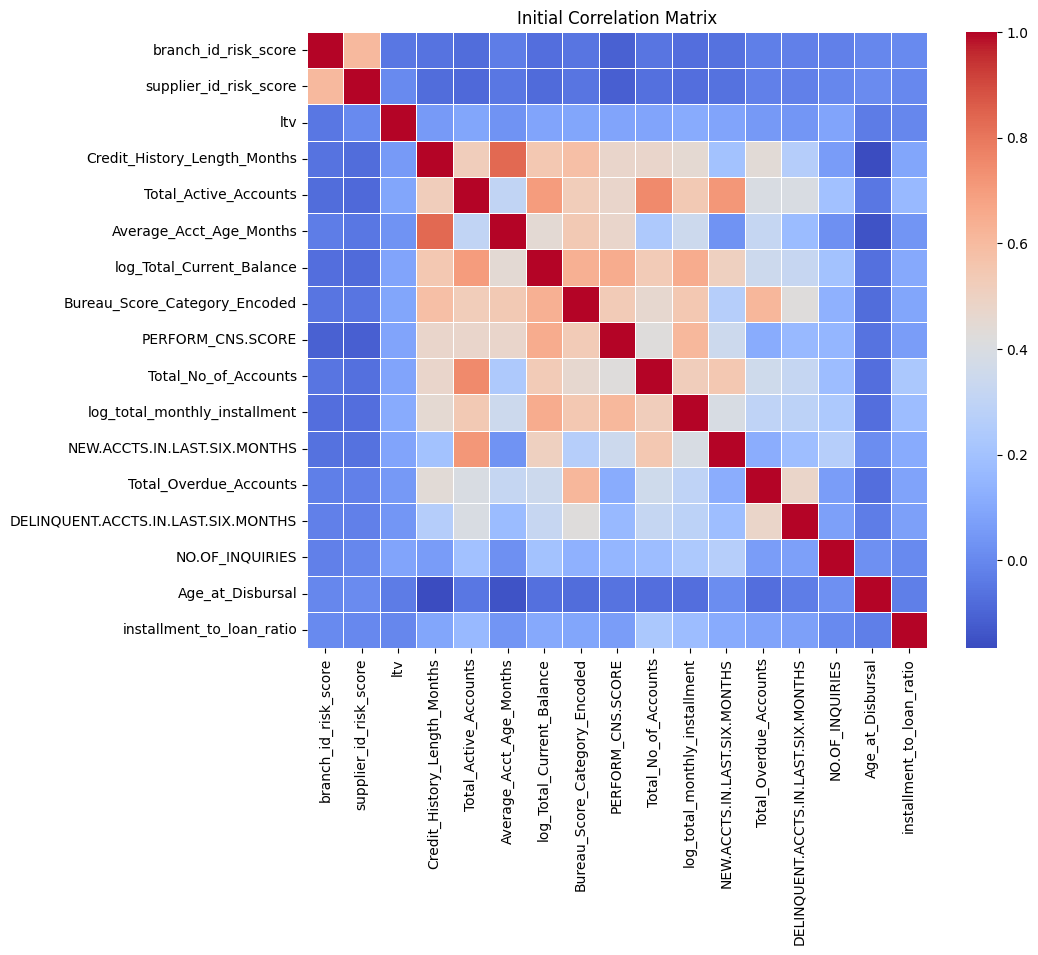

Starting VIF Calculation (Threshold=10)...
All features have VIF <= 10. Max VIF=5.11
Features removed: 0


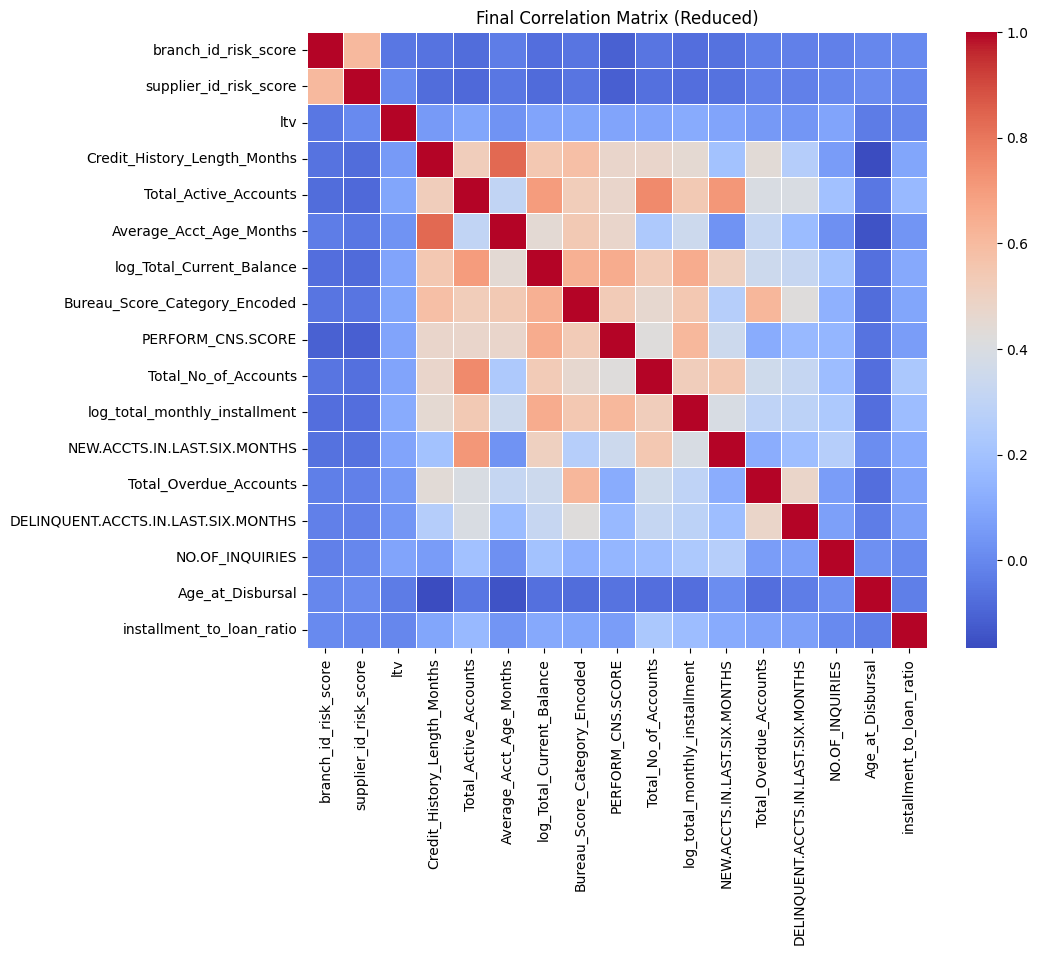

In [30]:
# --- PREPROCESSING (Same as Notebook 04 for consistency) ---

# 1. Cleaning
cols_to_drop = ['UniqueID', 'Sr. NO', 'MobileNo_Avl_Flag', 'Employee_code_ID', 'Current_pincode_ID']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Target Encoding
def apply_smoothed_encoding(df, target_col, id_cols, m=15):
    global_mean = df[target_col].mean()
    for col in id_cols:
        agg = df.groupby(col)[target_col].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']
        smooth_val = (counts * means + m * global_mean) / (counts + m)
        df[f'{col}_risk_score'] = df[col].map(smooth_val)
        df.drop(columns=[col], inplace=True)
    return df

ids_to_encode = ['branch_id', 'supplier_id', 'manufacturer_id', 'State_ID']
df = apply_smoothed_encoding(df, 'loan_default', ids_to_encode)

# 3. Derived Features
df['down_payment'] = df['asset_cost'] - df['disbursed_amount']
df['total_monthly_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']
df['installment_to_loan_ratio'] = df['total_monthly_installment'] / (df['disbursed_amount'] + 1)

# 4. Dates
def convert_to_months(duration_str):
    import re
    if pd.isna(duration_str) or duration_str == "": return 0
    years = re.findall(r'(\d+)yrs', duration_str)
    months = re.findall(r'(\d+)mon', duration_str)
    total = 0
    if years: total += int(years[0]) * 12
    if months: total += int(months[0])
    return total

df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], dayfirst=True)
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], dayfirst=True)
df['Age_at_Disbursal'] = (df['DisbursalDate'] - df['Date.of.Birth']).dt.days // 365
df['Disbursal_Month'] = df['DisbursalDate'].dt.month
df['Average_Acct_Age_Months'] = df['AVERAGE.ACCT.AGE'].apply(convert_to_months)
df['Credit_History_Length_Months'] = df['CREDIT.HISTORY.LENGTH'].apply(convert_to_months)

df.drop(columns=['Date.of.Birth', 'DisbursalDate', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], inplace=True)

# 5. Bureau scores
def group_bureau_score(desc):
    if desc in ['A-Very Low Risk', 'B-Very Low Risk', 'C-Very Low Risk', 'D-Very Low Risk']:
        return 1 # Very Low
    elif desc in ['E-Low Risk', 'F-Low Risk', 'G-Low Risk']:
        return 2 # Low
    elif desc in ['H-Medium Risk', 'I-Medium Risk']:
        return 3 # Medium
    elif desc in ['J-High Risk', 'K-High Risk']:
        return 4 # High
    elif desc in ['L-Very High Risk', 'M-Very High Risk']:
        return 5 # Very High
    else:
        return 0 # No History

df['Bureau_Score_Category_Encoded'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].apply(group_bureau_score)

# 6. Aggregations (Bureau)
df['Total_No_of_Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df['Total_Active_Accounts'] = df['PRI.ACTIVE.ACCTS'] + df['SEC.ACTIVE.ACCTS']
df['Total_Overdue_Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df['Total_Current_Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']

# Log transforms
for col in ['disbursed_amount', 'asset_cost', 'down_payment', 'total_monthly_installment', 'Total_Current_Balance']:
    df[f'log_{col}'] = np.log1p(df[col])
    df[f'log_{col}'] = df[f'log_{col}'].replace([np.inf, -np.inf], 0).fillna(0)

# Final features selection
features_to_keep = [
    'branch_id_risk_score', 'supplier_id_risk_score', 'ltv', 
    'Credit_History_Length_Months', 'Total_Active_Accounts', 
    'Average_Acct_Age_Months', 'log_Total_Current_Balance', 
    'Bureau_Score_Category_Encoded', 'PERFORM_CNS.SCORE', 
    'Total_No_of_Accounts', 'log_total_monthly_installment', 
    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'Total_Overdue_Accounts', 
    'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 
    'NO.OF_INQUIRIES', 'Age_at_Disbursal', 'installment_to_loan_ratio'
]

X = df[features_to_keep]
y = df['loan_default']

# Train/Test Split (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scale_pos_weight = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Class Imbalance Ratio (Neg/Pos): {scale_pos_weight:.2f}")

# --- NEW: Multicollinearity Check & Feature Removal ---
print("\n--- Checking for Multicollinearity & Removing High VIF Features ---")

# 1. Correlation Matrix (Initial)
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Initial Correlation Matrix')
plt.show()

# 2. Iterative VIF Removal
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant

    # Use a sample for speed if dataset is too large (>50k)
    calc_data = X_train.sample(50000, random_state=42) if len(X_train) > 50000 else X_train
    
    print(f"Starting VIF Calculation (Threshold=10)...")
    
    reduced_features = list(X_train.columns)
    while True:
        # subset data
        X_subset = calc_data[reduced_features]
        X_const = add_constant(X_subset)
        
        # Calculate VIF
        vif_series = pd.Series(
            [variance_inflation_factor(X_const.values, i+1) for i in range(len(X_subset.columns))],
            index=X_subset.columns
        )
        
        max_vif = vif_series.max()
        if max_vif > 10:
            feature_to_drop = vif_series.idxmax()
            print(f"  Dropping '{feature_to_drop}' (VIF={max_vif:.2f})")
            reduced_features.remove(feature_to_drop)
        else:
            print(f"All features have VIF <= 10. Max VIF={max_vif:.2f}")
            break
            
    # Update X_train and X_test
    print(f"Features removed: {len(X_train.columns) - len(reduced_features)}")
    X_train = X_train[reduced_features]
    X_test = X_test[reduced_features] # Sync test set
    
except Exception as e:
    print(f"VIF Removal skipped due to error: {e}")

# 3. Final Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Final Correlation Matrix (Reduced)')
plt.show()

## 2. Define Base Models
We use a wrapper class to ensure compatibility with sklearn 1.6+ which strictly checks estimator tags.

In [31]:
# Wrapper to fix sklearn 1.6+ compatibility issues with CatBoost/LGBM
from sklearn.base import BaseEstimator, ClassifierMixin

class ModelWrapper(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier" # Class attribute required for checks
    
    def __init__(self, model=None):
        self.model = model
    
    def fit(self, X, y):
        self.model.fit(X, y)
        self.classes_ = self.model.classes_
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def __sklearn_tags__(self):
        tags = super().__sklearn_tags__()
        tags.estimator_type = "classifier"
        return tags

# 1. XGBoost
xgb_base = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False
)
# Wrapping XGBoost as well for consistency, though recent versions are usually compatible
clf1 = ModelWrapper(xgb_base)

# 2. CatBoost
cat_base = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=0,
    allow_writing_files=False
)
clf2 = ModelWrapper(cat_base)

# 3. LightGBM
lgb_base = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=-1
)
clf3 = ModelWrapper(lgb_base)

## 3. Soft Voting Classifier
Averages predicted probabilities. Good if models make different errors.

In [32]:
voting_clf = VotingClassifier(
    estimators=[('xgb', clf1), ('cat', clf2), ('lgb', clf3)],
    voting='soft'  # 'soft' averages probabilities, 'hard' counts votes
)

print("Training Voting Classifier... (this takes a moment)")
voting_clf.fit(X_train, y_train)

y_prob_vote = voting_clf.predict_proba(X_test)[:, 1]
print(f"Voting Classifier ROC-AUC: {roc_auc_score(y_test, y_prob_vote):.4f}")

Training Voting Classifier... (this takes a moment)
Voting Classifier ROC-AUC: 0.6775


## 4. Stacking Classifier
Uses Logistic Regression to learn the best mix of the base models.

In [33]:
meta_learner = LogisticRegression(random_state=42)

stacking_clf = StackingClassifier(
    estimators=[('xgb', clf1), ('cat', clf2), ('lgb', clf3)],
    final_estimator=meta_learner,
    cv=3,
    passthrough=False 
)

print("Training Stacking Classifier... (Model training x CV folds)")
stacking_clf.fit(X_train, y_train)

y_prob_stack = stacking_clf.predict_proba(X_test)[:, 1]
print(f"Stacking Classifier ROC-AUC: {roc_auc_score(y_test, y_prob_stack):.4f}")

Training Stacking Classifier... (Model training x CV folds)
Stacking Classifier ROC-AUC: 0.6777


## 5. Evaluation & Conclusion

Best Threshold (Stacking): 0.2169
Max F1-Score (Stacking): 0.4246

--- Stacking Classifier Report ---
              precision    recall  f1-score   support

           0       0.86      0.60      0.70     36509
           1       0.31      0.66      0.42     10122

    accuracy                           0.61     46631
   macro avg       0.59      0.63      0.56     46631
weighted avg       0.74      0.61      0.64     46631



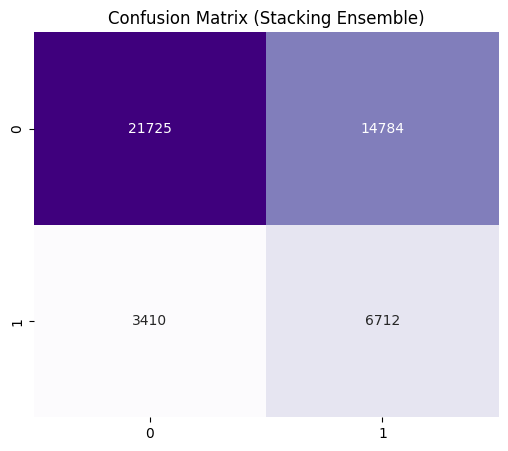

In [34]:
def optimal_threshold_search(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

best_thresh_stack, best_f1_stack = optimal_threshold_search(y_test, y_prob_stack)
print(f"Best Threshold (Stacking): {best_thresh_stack:.4f}")
print(f"Max F1-Score (Stacking): {best_f1_stack:.4f}")

y_pred_stack = (y_prob_stack >= best_thresh_stack).astype(int)

print("\n--- Stacking Classifier Report ---")
print(classification_report(y_test, y_pred_stack))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_stack), annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix (Stacking Ensemble)')
plt.show()